# Cloudy

This is the official implementation for the paper: *"Light Transport-aware Diffusion Posterior Sampling for Single View Reconstruction of Volumes"*. The project is based on [**rendervous**](https://www.github.com/rendervous).


In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Let's start with required imports. Cloudy is based on rendervous and therefore in pytorch.

In [2]:
import torch
import cloudy
import matplotlib.pyplot as plt

The main object in cloudy is a `Pipeline`. This object is created bound to a specific work folder to save intermediate results of the workflow. Required tasks to train the generative model are:

- Training a decoder (`run_train_decoder`): From a folder with the grids of clouds dataset, a joint decoder is trained with a subset of the clouds.
- Encoding clouds (`run_encoding`): Get the last decoder and use for encoding all clouds of the dataset with SGD.
- Enhancing clouds dataset (`run_enhancing`): From encoded latents, applies transformations to the volumes and the latents, creating new latents with transformed volumes encoded.
- Compute Normalization Stats (`run_compute_normalization_stats`): From enhanced latents, computes the range for each feature channel centered in the mode.
- Train diffuser: Use the normalized latents to train a diffusion model to replicate the latents dataset.

After this process, required objects are the decoder (with an upsampler), the normalization stats and the diffuser. A version pre-trained can be automatically downloaded. 

In [3]:
pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1gtdgT9R4ZpxxC-8Id77N5MSw0j7jops6
To: /home/leonard/rendervous.project/cloudy_project/examples/test/pretrained.zip
100%|██████████| 294M/294M [00:03<00:00, 78.0MB/s] 


Without all intermediate outputs, the pipeline functionality is limited but main functions are present. Let's start generating a cloud.

In [4]:
latent = pipeline.generate_latent(samples=100)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Unconditional sampling DDIM: 100%|██████████| 100/100 [00:02<00:00, 44.78it/s]


The diffuser operates in the space of latent representations. To decode a grid we should get a representation (a model combining the upsampler with the latent decoder) and evaluate a regular grid of points. 

In [5]:
with torch.no_grad():
    grid = pipeline.from_latent_to_grid(latent, resolution=256).clamp_min(0.0)

A slice of the generated cloud can be visualized as follows.

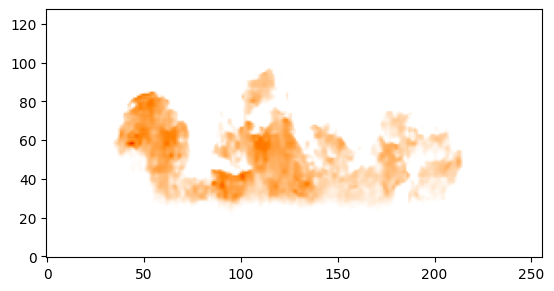

In [6]:
plt.imshow(grid[:, :, grid.shape[2]//2, 0].cpu().T, cmap='gist_heat_r', vmin=0.0, vmax=0.6)
plt.gca().invert_yaxis()
plt.show()

**Cloudy** includes some tools for rendering and modeling. To render the volume as a cloud we need a set of camera poses, and environment, the volume grid of the densities, and other physical parameters of the cloud.

stdin


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


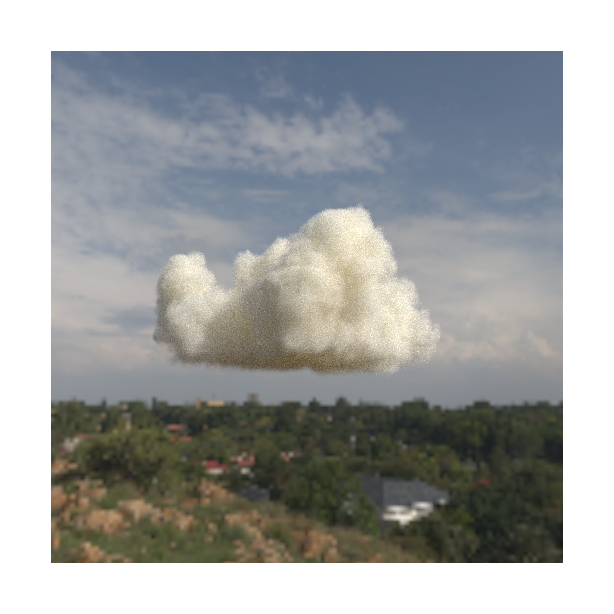

In [7]:
import vulky.datasets as datasets

with torch.no_grad():
    camera_poses = cloudy.camera_poses((3.0, -0.5, -0.4))
    environment = datasets.Images.environment_example
    # environment = torch.zeros(64, 128, 3, device='cuda')
    # environment[10,0] = 1600
    im = cloudy.scattered(grid * 300, 
                          camera_poses=camera_poses,
                          scattering_albedo=(0.99, 0.98, 0.94),
                          environment=environment,
                          phase_g=0.0,
                          majorant=grid.max()*300,
                          # kwargs
                          width=512, 
                          height=512,
                          jittered=True,
                          samples=128
                          )
    plt.figure(figsize=(1, 1), dpi=512)
    plt.imshow(im[0].cpu() ** (1.0/2.2))
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.tight_layout(pad=0.0)
    plt.show()